In [4]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

Reconstruct all neurons by looking at the neuron ids associated with the dendrite fields.

In [7]:
dendrites = h5py.File('dendrites.hdf5', 'r')
dendrites['dendrites']['agglomerate']

<HDF5 group "/dendrites/agglomerate" (11400 members)>

In [8]:
segments = h5py.File('segments.hdf5', 'r')
segment_positions = np.array(segments['segments']['position'])
vc = np.array(segments['segments']['voxelCount'])

num_voxels = []
neuron_id = []
for i, agg_id in enumerate(dendrites['dendrites']['agglomerate'].keys()):
    ds = dendrites['dendrites']['agglomerate'][agg_id]
    num_voxels.append(vc[np.array(ds)].sum())
    
neuronId = np.array(dendrites['dendrites']['neuronId'])
neuronId[neuronId != 0]

array([ 1,  3,  4,  5,  7,  8, 10, 13, 14, 19, 20, 21, 22, 23, 25, 27, 29,
       30, 31, 32, 36, 38, 39, 40, 42, 43, 44, 49, 51, 52, 53, 54, 55, 59,
       60, 61, 63, 64, 66, 68, 70, 71, 74, 75, 76, 77, 78, 79, 80, 82, 83,
       84, 85, 86, 87, 88, 89, 91,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
       96, 28, 65, 11, 72, 33, 75, 41,  6, 91, 35, 13,  2, 22, 39, 89,  9,
       25, 27,  7, 88, 59, 61, 67, 36, 58, 23, 21,  3, 77, 24, 87, 55,  5,
       82, 60, 79, 78, 51, 34, 86, 14, 20, 37, 46, 49, 31, 66, 85, 16, 40,
       68, 10, 30, 32, 54, 17, 63, 84, 43, 64, 29, 57, 69, 83, 92, 52,  4,
       74, 53, 15, 44, 71

In [9]:
# Reconstruct all the neurons
import collections

d = collections.defaultdict(lambda: [])
for i, id in enumerate(neuronId):
    if id > 0:
        # Append the dendrite ids to the right slot.
        d[id] += np.array(dendrites['dendrites']['agglomerate'][str(i + 1)]).tolist()

In [16]:
import numpy_indexed as npi

def repaint(neuron_segments, segment_positions, voxel_pos):
    cube = h5py.File('x%dy%dz%d.hdf5' % voxel_pos, 'r')
    data = np.array(cube['data'])
    unique_values = set(np.unique(data.ravel()))
    
    value_map = {idx: 0 for idx in unique_values}
    for k in neuron_segments.keys():
        values_to_remap = set(np.array(neuron_segments[k])).intersection(unique_values)
        for j in values_to_remap:
            value_map[j] = k
    return data, value_map

data, value_map = repaint(d, segment_positions, (0, 0, 0))

In [17]:
%load_ext cython

In [18]:
%%cython -a
import numpy as np
cimport cython

@cython.boundscheck(False)
def c_remap(unsigned int[:] data, unsigned int[:] the_map):
    new_data = np.zeros(data.size, dtype=np.uint32)
    cdef unsigned int[:] new_data_view = new_data
    cdef int M = data.size
    
    for j in range(M):
        new_data_view[j] = the_map[data[j]]
    return new_data

In [19]:
def remap(data, value_map):
    value_arr = np.zeros(max(value_map.keys()) + 1, dtype=np.uint32)
    for k, v in value_map.items():
        value_arr[k] = v
    remapped = c_remap(data.ravel(), value_arr)
    return remapped.reshape(data.shape)

remapped = remap(data, value_map)

In [20]:
f = h5py.File('x0y0z0_remapped.hdf5', 'w')
f.create_dataset('data', remapped.shape, compression="gzip", data=remapped)
f.close()

In [21]:
print(np.unique(remapped.ravel()))

[ 0  7 19 20 32 33 37 38 49 53 58 68 70 79 88 89]


In [178]:
value_map

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,
 122: 0,
 12

In [175]:
unique_values[:9034][-1]

9033

In [174]:
list(value_map.keys())[:9034][-1]

9033

In [ ]:
cube = h5py.File('x0y0z0.hdf5', 'r')
subd = cube['data'][:512, :512, :512]
xi, yi, zi = np.meshgrid(np.arange(512) + 1, np.arange(512) + 1, np.arange(512) + 1)

In [57]:
selidx = subd == 2
(zi * (selidx)).sum() / (selidx).sum()

170.21761658031087

In [8]:
counts = np.array(f['segments'][0])
which_ones = counts.argsort()
counts.sort()

In [59]:
which_ones[-3]

9063897

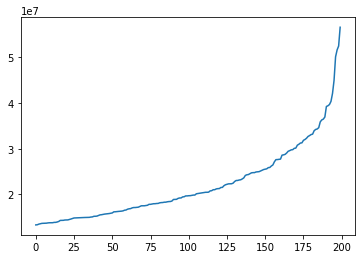

In [28]:
plt.plot(counts[-200:])


In [40]:
P = np.array(f['segments']['position'])
P[:, which_ones[-4]]

array([4462, 5933, 2048], dtype=uint32)

In [9]:
tinydata = cube['data'][:256, :256, :256]

In [10]:
f = h5py.File('x0y0z0_subset.hdf5', 'w')
f['data'] = tinydata
f.close()

In [46]:
C = np.array(cube['data'])

In [52]:
C.max()

8171152

In [61]:
counts = np.array([np.sum(C == x) for x in which_ones[-30:-20]])
counts

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
counts

array([0])